In [1]:
%matplotlib inline

from enum import Enum

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from ipywidgets import interact, IntSlider

from boundary import plot_decision_boundary
from gaussian import n_gaussians

np.random.seed(0)

In [2]:
class Phase(Enum):
    Train = 0
    Validation = 1
    Predict = 2

In [3]:
class Model:
    def __init__(self, batch_size, input_dims, phase = Phase.Predict):
        self._x = x = tf.placeholder(tf.float32, shape=[batch_size, input_dims])
        
        if phase != Phase.Predict:
            self._y = y = tf.placeholder(tf.int32, shape=[batch_size])

        w = tf.get_variable("w", shape = [input_dims, 1])
        b = tf.get_variable("b", shape = 1)

        logits = tf.matmul(x, w) + b
        logits = tf.reshape(logits, [-1])

        if phase == Phase.Train:
            losses = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.cast(y, tf.float32), logits = logits)
            self._loss = loss = tf.reduce_sum(losses)    
            self._train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
        else:
            self._probs = probs = tf.sigmoid(logits)
            self._labels = tf.cast(tf.round(probs), tf.int32)
            
        if phase == Phase.Validation:
            correct = tf.equal(y, self.labels)
            self._accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    @property
    def x(self):
        return self._x
        
    @property
    def y(self):
        return self._y
    
    @property
    def labels(self):
        return self._labels

    @property
    def loss(self):
        return self._loss

    @property
    def train_op(self):
        return self._train_op

    @property
    def probs(self):
        return self._probs
        
    @property
    def accuracy(self):
        return self._accuracy

In [4]:
X_train, Y_train = n_gaussians(np.array([[0.8, 0.2],[0.2, 0.8]]), np.array([0, 1], dtype=np.float32), 100, stddev=0.1)
X_validate, Y_validate = n_gaussians(np.array([[0.8, 0.2],[0.2, 0.8]]), np.array([0, 1], dtype=np.float32), 100, stddev=0.1)

In [5]:
tf.reset_default_graph()
sess = tf.Session()

with tf.variable_scope("model", reuse=False):
    train_model = Model(X_train.shape[0], X_train.shape[1], phase = Phase.Train)
        
with tf.variable_scope("model", reuse=True):
    validation_model = Model(X_validate.shape[0], X_validate.shape[1], phase = Phase.Validation)
    
with tf.variable_scope("model", reuse=True):
    predict_model = Model(X_validate.shape[0], X_validate.shape[1], phase = Phase.Predict)
    
sess.run(tf.global_variables_initializer())
    
for i in range(10):
    epoch_loss, _ = sess.run([train_model.loss, train_model.train_op],
                            {train_model.x: X_train, train_model.y: Y_train})
    accuracy, = sess.run([validation_model.accuracy],
                        {validation_model.x: X_validate, validation_model.y: Y_validate})
    print(epoch_loss, accuracy)

68.2633 0.96
48.8112 1.0
37.1508 1.0
29.8023 1.0
24.8552 1.0
21.33 1.0
18.6999 1.0
16.6658 1.0
15.0467 1.0
13.7276 1.0


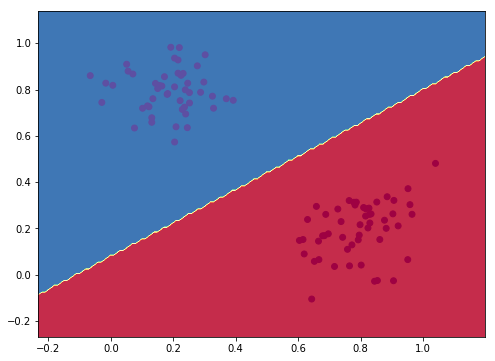

In [6]:
fig = plt.figure(figsize=(8, 6))
sub = fig.add_subplot(111)

def classify(x):
    return sess.run([predict_model.labels], {predict_model.x: x})[0]

plot_decision_boundary(sub, lambda x: classify(x), X_validate, Y_validate,
                           batch_size = X_validate.shape[0],
                           x_range = (X_validate[:,0].min(), X_validate[:,0].max()),
                           y_range = (X_validate[:,1].min(), X_validate[:,1].max()))

In [7]:
sess.close()